# Chapter 21: An Experimental Perspective on the Instrumental Variable

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import linearmodels as lm
from joblib import Parallel, delayed

# viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

font = {"family": "IBM Plex Sans Condensed", "weight": "normal", "size": 10}
plt.rc("font", **font)
plt.rcParams["figure.figsize"] = (10, 10)
%matplotlib inline

from utils import *

np.random.seed(42)
%load_ext autoreload
%autoreload 1

%load_ext watermark
%watermark --iversions

graphviz         : 0.20.1
scipy            : 1.11.1
linearmodels     : 5.3
statsmodels      : 0.14.0
pandas           : 2.0.3
matplotlib       : 3.7.2
numpy            : 1.24.3
seaborn          : 0.13.0
matplotlib_inline: 0.1.6



In [2]:
def IV_Wald(Z, D, Y):
    tau_D = np.mean(D[Z == 1]) - np.mean(D[Z == 0])
    tau_Y = np.mean(Y[Z == 1]) - np.mean(Y[Z == 0])
    CACE = tau_Y / tau_D
    return np.array([tau_D, tau_Y, CACE])


def IV_Wald_delta(Z, D, Y):
    est = IV_Wald(Z, D, Y)
    AdjustedY = Y - D * est[2]
    VarAdj = np.var(AdjustedY[Z == 1], ddof=1) / np.sum(Z) + np.var(
        AdjustedY[Z == 0], ddof=1
    ) / np.sum(1 - Z)
    return np.array([est[2], np.sqrt(VarAdj) / abs(est[0])])


def IV_Wald_bootstrap(Z, D, Y, n_boot=200, k=-1):
    est = IV_Wald(Z, D, Y)
    n = len(Z)

    def bootfn(*args):
        # draw indices
        ids = np.random.choice(np.arange(n), size=n, replace=True)
        return IV_Wald(Z[ids], D[ids], Y[ids])[2]

    boot_est = Parallel(n_jobs=k)(delayed(bootfn)(i) for i in range(int(n_boot)))
    boot_est = np.vstack(boot_est)
    return np.array([est[2], boot_est.flatten().std()])


## without covariates


In [3]:
def ivsim_nocovars(shares=[1 / 2, 1 / 4, 1 / 4], *args):
    n = 200
    D0 = np.r_[
        np.repeat(0, int(n * shares[0])),
        np.repeat(1, int(n * shares[1])),
        np.repeat(0, int(n * shares[2])),
    ]
    D1 = np.r_[
        np.repeat(1, int(n * shares[0])),
        np.repeat(1, int(n * shares[1])),
        np.repeat(0, int(n * shares[2])),
    ]
    Y0 = np.r_[
        np.random.normal(1, size=int(n * shares[0])),
        np.random.normal(0, size=int(n * shares[1])),
        np.random.normal(2, size=int(n * shares[2])),
    ]
    Y1 = Y0.copy()
    Y1[np.arange(int(n * shares[0]))] = np.random.normal(3, 1, int(n * shares[0]))
    Z = np.random.binomial(1, 0.5, n)
    D = Z * D1 + (1 - Z) * D0
    Y = Z * Y1 + (1 - Z) * Y0
    ret = np.array(
        [
            IV_Wald(Z, D, Y)[2],
            IV_Wald_delta(Z, D, Y)[1],
            IV_Wald_bootstrap(Z, D, Y, k=1)[1],
        ]
    )
    return ret


### strong IV 

In [4]:
MC = 2000
res = Parallel(n_jobs=-1)(
    delayed(ivsim_nocovars)([1 / 2, 1 / 4, 1 / 4], i) for i in range(int(MC))
)
res = np.vstack(res)

In [5]:
cent, sd = res[:, 0].mean(), res[:, 0].std()
print(cent, sd)
print(res[:, 2].mean())

2.0459278335318825 0.5337581637120559
0.5562637573206064


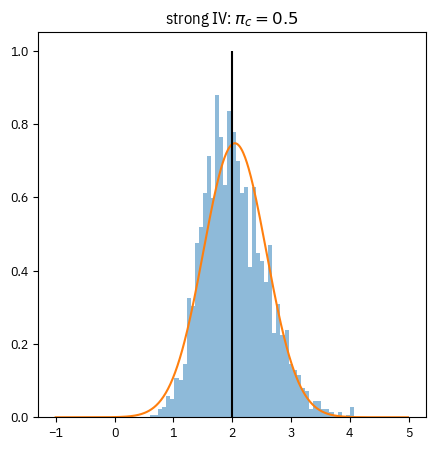

In [6]:
f, ax = plt.subplots(figsize=(5, 5))
ax.hist(res[:, 0], bins=50, density=True, alpha=0.5)
x_axis = np.arange(-1, 5, 0.01)

ax.plot(x_axis, sp.stats.norm.pdf(x_axis, loc=cent, scale=sd))
ax.vlines(2, 0, 1, color="k")
ax.set_title(r"strong IV: $\pi_c = 0.5$")
plt.show()

## weak IV

In [ ]:
MC = 2000
res = Parallel(n_jobs=-1)(
    delayed(ivsim_nocovars)([1 / 5, 2 / 5, 2 / 5], i) for i in range(int(MC))
)
res = np.vstack(res)
res = np.ma.masked_invalid(res)  # remove infs from divide by zero

In [8]:
cent, sd = res[:, 0].mean(), res[:, 0].std()
print(cent, sd)
print(res[:, 1].mean())

2.2980928526598845 9.060489740223025
11.430861088387783


/home/alal/anaconda3/envs/metrics/lib/python3.11/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


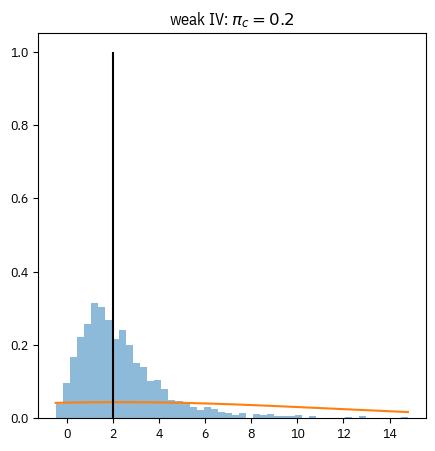

In [9]:
minr, maxr = np.percentile(res[:, 0], [0.5, 99.5])

f, ax = plt.subplots(figsize=(5, 5))
sims = res[:, 0]
ax.hist(
    np.where((sims > minr) & (sims < maxr), sims, 0), bins=50, density=True, alpha=0.5
)
x_axis = np.arange(minr, maxr, 0.01)
ax.plot(x_axis, sp.stats.norm.pdf(x_axis, loc=cent, scale=sd))
ax.vlines(2, 0, 1, color="k")
ax.set_title(r"weak IV: $\pi_c = 0.2$")
plt.show()

## weakest IV

In [ ]:
MC = 2000
res = Parallel(n_jobs=-1)(
    delayed(ivsim_nocovars)([1 / 10, 2 / 5, 1 / 2], i) for i in range(int(MC))
)
res = np.vstack(res)
res = np.ma.masked_invalid(res)  # remove infs from divide by zero

In [11]:
cent, sd = res[:, 0].mean(), res[:, 0].std()
print(cent, sd)
print(res[:, 1].mean())

3.9621044093432425 44.27081120055434
280.39027826364907


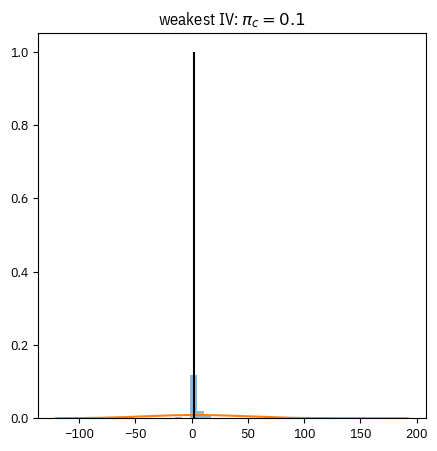

In [12]:
minr, maxr = np.percentile(res[:, 0], [0.5, 99.5])

f, ax = plt.subplots(figsize=(5, 5))
sims = res[:, 0]
ax.hist(
    np.where((sims > minr) & (sims < maxr), sims, 0), bins=50, density=True, alpha=0.5
)
x_axis = np.arange(minr, maxr, 0.01)
ax.plot(x_axis, sp.stats.norm.pdf(x_axis, loc=cent, scale=sd))
ax.vlines(2, 0, 1, color="k")
ax.set_title(r"weakest IV: $\pi_c = 0.1$")
plt.show()

## With Covariates


In [13]:
def IV_Lin(Z, D, Y, X):
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    tau_D = (
        sm.OLS(D, np.c_[sm.add_constant(Z), X, Z.reshape(-1, 1) * X]).fit().params[1]
    )
    tau_Y = (
        sm.OLS(Y, np.c_[sm.add_constant(Z), X, Z.reshape(-1, 1) * X]).fit().params[1]
    )
    CACE = tau_Y / tau_D
    return np.array([tau_D, tau_Y, CACE])


def IV_Lin_bootstrap(Z, D, Y, X, n_boot=200, k=-1):
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    est = IV_Lin(Z, D, Y, X)
    n = len(Z)

    def bootfn(*args):
        id = np.random.choice(np.arange(n), size=n, replace=True)
        return IV_Lin(Z[id], D[id], Y[id], X[id, :])[2]

    boot_est = Parallel(n_jobs=k)(delayed(bootfn)(i) for i in range(int(n_boot)))
    boot_est = np.vstack(boot_est)
    return np.array([est[2], boot_est.flatten().std()])

In [14]:
def ivsim_covars(shares=[1 / 2, 1 / 4, 1 / 4], *args):
    n = 200
    X = np.random.normal(size=int(n * 2)).reshape((n, 2))
    D0 = np.r_[
        np.repeat(0, int(n * shares[0])),
        np.repeat(1, int(n * shares[1])),
        np.repeat(0, int(n * shares[2])),
    ]
    D1 = np.r_[
        np.repeat(1, int(n * shares[0])),
        np.repeat(1, int(n * shares[1])),
        np.repeat(0, int(n * shares[2])),
    ]
    Y0 = np.r_[
        np.random.normal(1, size=int(n * shares[0])),
        np.random.normal(0, size=int(n * shares[1])),
        np.random.normal(2, size=int(n * shares[2])),
    ] + X @ np.array([1, -1])
    Y1 = Y0.copy()
    Y1[np.arange(int(n * shares[0]))] = np.random.normal(3, 1, int(n * shares[0])) + +X[
        np.arange(int(n * shares[0])), :
    ] @ np.array([1, -1])
    Z = np.random.binomial(1, 0.5, n)
    D = Z * D1 + (1 - Z) * D0
    Y = Z * Y1 + (1 - Z) * Y0
    return IV_Lin_bootstrap(Z, D, Y, X, k=1)


### Strong IV

In [15]:
MC = 2000
res = Parallel(n_jobs=-1)(
    delayed(ivsim_covars)([1 / 2, 1 / 4, 1 / 4], i) for i in range(int(MC))
)
res = np.vstack(res)

In [16]:
cent, sd = res[:, 0].mean(), res[:, 0].std()
print(cent, sd)
print(res[:, 1].mean())

2.041022022570901 0.5542291812774217
0.5594014563842343


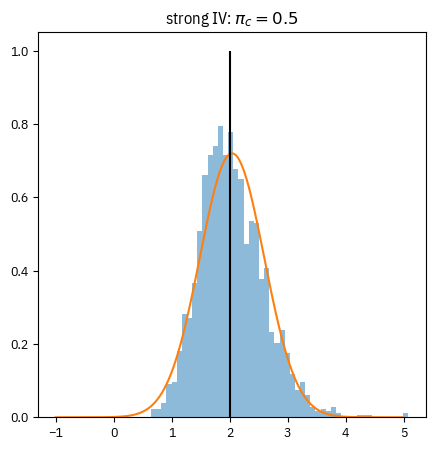

In [17]:
f, ax = plt.subplots(figsize=(5, 5))
ax.hist(res[:, 0], bins=50, density=True, alpha=0.5)
x_axis = np.arange(-1, 5, 0.01)

ax.plot(x_axis, sp.stats.norm.pdf(x_axis, loc=cent, scale=sd))
ax.vlines(2, 0, 1, color="k")
ax.set_title(r"strong IV: $\pi_c = 0.5$")
plt.show()

### Weak IV

In [18]:
MC = 2000
res = Parallel(n_jobs=-1)(
    delayed(ivsim_covars)([1 / 5, 2 / 5, 2 / 5], i) for i in range(int(MC))
)
res = np.vstack(res)

In [19]:
cent, sd = res[:, 0].mean(), res[:, 0].std()
print(cent, sd)
print(res[:, 1].mean())

2.1504851844132458 20.437946561705076
101.34710547345787


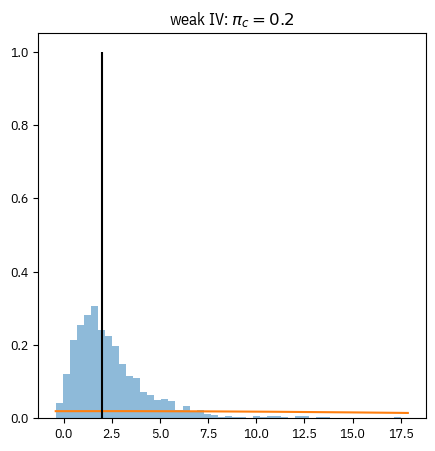

In [20]:
minr, maxr = np.percentile(res[:, 0], [0.5, 99.5])

f, ax = plt.subplots(figsize=(5, 5))
sims = res[:, 0]
ax.hist(
    np.where((sims > minr) & (sims < maxr), sims, 0), bins=50, density=True, alpha=0.5
)
x_axis = np.arange(minr, maxr, 0.01)
ax.plot(x_axis, sp.stats.norm.pdf(x_axis, loc=cent, scale=sd))
ax.vlines(2, 0, 1, color="k")
ax.set_title(r"weak IV: $\pi_c = 0.2$")
plt.show()

### Weakest IV

In [21]:
MC = 2000
res = Parallel(n_jobs=-1)(
    delayed(ivsim_covars)([1 / 10, 2 / 5, 1 / 2], i) for i in range(int(MC))
)
res = np.vstack(res)

In [22]:
cent, sd = res[:, 0].mean(), res[:, 0].std()
print(cent, sd)
print(res[:, 1].mean())

-19.37707093642744 1170.4776931064248
3529.2840088053103


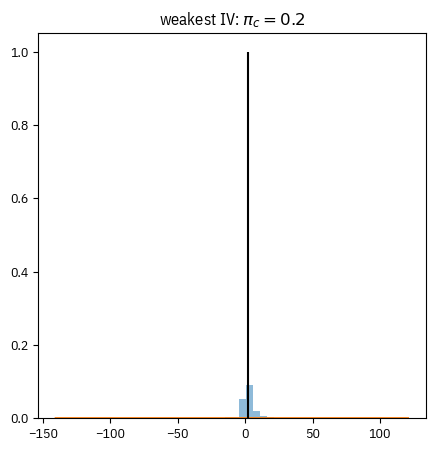

In [23]:
minr, maxr = np.percentile(res[:, 0], [0.5, 99.5])

f, ax = plt.subplots(figsize=(5, 5))
sims = res[:, 0]
ax.hist(
    np.where((sims > minr) & (sims < maxr), sims, 0), bins=50, density=True, alpha=0.5
)
x_axis = np.arange(minr, maxr, 0.01)
ax.plot(x_axis, sp.stats.norm.pdf(x_axis, loc=cent, scale=sd))
ax.vlines(2, 0, 1, color="k")
ax.set_title(r"weakest IV: $\pi_c = 0.2$")
plt.show()

## WeakIV Robust Inference: Fieller Anderson Rubin Confidence Interval

In [24]:
def FARci(Z, D, Y, Lower, Upper, grid):
    CIrange = np.arange(Lower, Upper, grid)

    def pvfun(t):
        Y_t = Y - t * D
        TauAdj = Y_t[Z == 1].mean() - Y_t[Z == 0].mean()
        VarAdj = np.var(Y_t[Z == 1], ddof=1) / np.sum(Z) + np.var(
            Y_t[Z == 0], ddof=1
        ) / np.sum(1 - Z)
        Tstat = TauAdj / np.sqrt(VarAdj)
        return (1 - sp.stats.norm.cdf(np.abs(Tstat))) * 2

    Pvalue = Parallel(n_jobs=-1)(delayed(pvfun)(t) for t in CIrange)
    return CIrange, Pvalue

In [25]:
def linestimator(Z, Y, X):
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    n, p = X.shape
    # fully interacted OLS
    Xmat = np.c_[sm.add_constant(Z), X, Z.reshape(-1, 1) * X]
    m = sm.OLS(Y, Xmat).fit(cov_type="HC2")
    est, vehw = m.params[1], m.bse[1] ** 2
    # super-population correction
    inter = m.params[-p:]  # (β_1 - β_0) term - last p elements of coef
    # (β_1 - β_0)' Σ (β_1 - β_0) / n
    superCorr = np.sum(inter * (np.cov(X.T) @ inter)) / n
    vsuper = vehw + superCorr
    return est, np.sqrt(vehw), np.sqrt(vsuper)


def FARciX(Z, D, Y, X, Lower, Upper, grid):
    CIrange = np.arange(Lower, Upper, grid)

    def pvfun(t):
        Y_t = Y - t * D
        linest = linestimator(Z, Y_t, X)
        Tstat = linest[0] / linest[2]
        return (1 - sp.stats.norm.cdf(np.abs(Tstat))) * 2

    Pvalue = Parallel(n_jobs=-1)(delayed(pvfun)(t) for t in CIrange)
    return CIrange, Pvalue

In [26]:
def ivsim_covars(shares=[1 / 2, 1 / 4, 1 / 4], *args):
    n = 200
    X = np.random.normal(size=int(n * 2)).reshape((n, 2))
    D0 = np.r_[
        np.repeat(0, int(n * shares[0])),
        np.repeat(1, int(n * shares[1])),
        np.repeat(0, int(n * shares[2])),
    ]
    D1 = np.r_[
        np.repeat(1, int(n * shares[0])),
        np.repeat(1, int(n * shares[1])),
        np.repeat(0, int(n * shares[2])),
    ]
    Y0 = np.r_[
        np.random.normal(1, size=int(n * shares[0])),
        np.random.normal(0, size=int(n * shares[1])),
        np.random.normal(2, size=int(n * shares[2])),
    ] + X @ np.array([1, -1])
    Y1 = Y0.copy()
    Y1[np.arange(int(n * shares[0]))] = np.random.normal(3, 1, int(n * shares[0])) + +X[
        np.arange(int(n * shares[0])), :
    ] @ np.array([1, -1])
    Z = np.random.binomial(1, 0.5, n)
    D = Z * D1 + (1 - Z) * D0
    Y = Z * Y1 + (1 - Z) * Y0
    return Z, D, Y, X

Text(0.5, 0.98, 'strong IV: $\\pi_c = 0.5$')

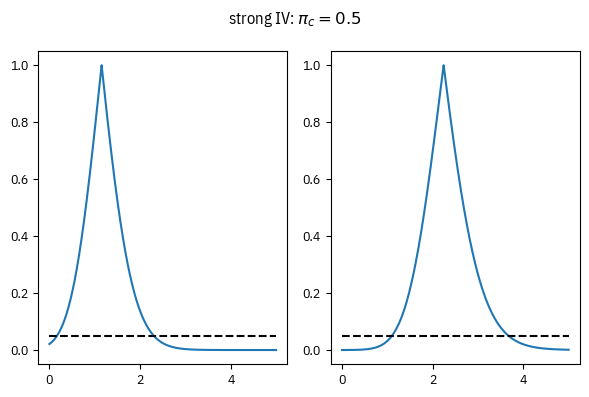

In [27]:
f, ax = plt.subplots(1, 2, figsize=(6, 4))
Z, D, Y, _ = ivsim_covars([1 / 2, 1 / 4, 1 / 4])
CI, Pv = FARci(Z, D, Y, 0, 5, 0.001)

ax[0].plot(CI, Pv)
ax[0].hlines(0.05, 0, 5, color="k", linestyle="--")

Z, D, Y, _ = ivsim_covars([1 / 2, 1 / 4, 1 / 4])
CI, Pv = FARci(Z, D, Y, 0, 5, 0.001)

ax[1].plot(CI, Pv)
ax[1].hlines(0.05, 0, 5, color="k", linestyle="--")

f.set_tight_layout(True)
f.suptitle(r"strong IV: $\pi_c = 0.5$")

Text(0.5, 0.98, 'strong IV: $\\pi_c = 0.2$')

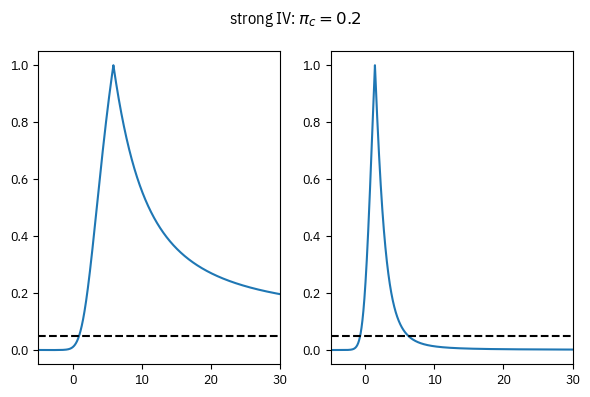

In [28]:
l, h = -5, 30
f, ax = plt.subplots(1, 2, figsize=(6, 4))
Z, D, Y, _ = ivsim_covars([1 / 5, 2 / 5, 2 / 5])
CI, Pv = FARci(Z, D, Y, l, h, 0.001)

ax[0].plot(CI, Pv)
ax[0].hlines(0.05, l, h, color="k", linestyle="--")
ax[0].set_xlim(l, h)

Z, D, Y, _ = ivsim_covars([1 / 5, 2 / 5, 2 / 5])
CI, Pv = FARci(Z, D, Y, l, h, 0.001)

ax[1].plot(CI, Pv)
ax[1].hlines(0.05, l, h, color="k", linestyle="--")
ax[1].set_xlim(l, h)
f.set_tight_layout(True)
f.suptitle(r"strong IV: $\pi_c = 0.2$")

Text(0.5, 0.98, 'strong IV: $\\pi_c = 0.1$')

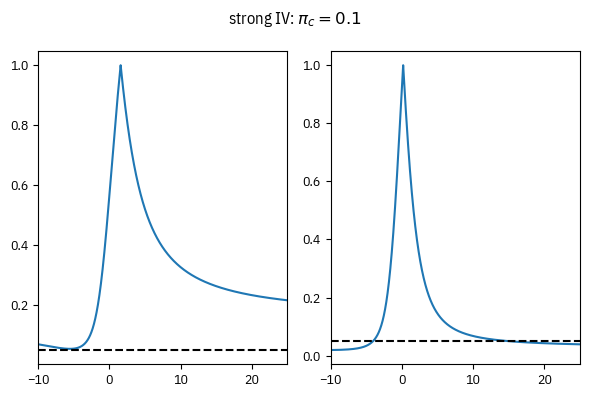

In [29]:
l, h = -10, 25
f, ax = plt.subplots(1, 2, figsize=(6, 4))
Z, D, Y, _ = ivsim_covars([1 / 10, 2 / 5, 1 / 2])
CI, Pv = FARci(Z, D, Y, l, h, 0.001)

ax[0].plot(CI, Pv)
ax[0].hlines(0.05, l, h, color="k", linestyle="--")
ax[0].set_xlim(l, h)

Z, D, Y, _ = ivsim_covars([1 / 10, 2 / 5, 1 / 2])
CI, Pv = FARci(Z, D, Y, l, h, 0.001)

ax[1].plot(CI, Pv)
ax[1].hlines(0.05, l, h, color="k", linestyle="--")
ax[1].set_xlim(l, h)
f.set_tight_layout(True)
f.suptitle(r"strong IV: $\pi_c = 0.1$")

# Application

In [30]:
import formulaic as fm

In [31]:
jobsdata = pd.read_csv("jobsdata.csv")
Z, D, Y = jobsdata.treat.values, jobsdata.comply.values, jobsdata.job_seek.values
X = (
    fm.Formula("~ -1 + sex + age + marital + nonwhite + educ + income")
    .get_model_matrix(data=jobsdata)
    .values
)

In [32]:
pd.DataFrame(
    np.c_[
        IV_Wald_delta(Z, D, Y),
        IV_Wald_bootstrap(Z, D, Y, n_boot=1e3),
        IV_Lin_bootstrap(Z, D, Y, X, n_boot=1e3),
    ].T,
    index=["delta", "bootstrap", "linestimator"],
    columns=["CACE", "SE"],
)

,CACE,SE
delta,0.108790,0.081027
bootstrap,0.108790,0.081694
linestimator,0.117633,0.081463


In [33]:
l, h = -0.2, 0.4
CI1, Pv1 = FARci(Z, D, Y, l, h, 0.001)
CI2, Pv2 = FARciX(Z, D, Y, X, l, h, 0.001)

Text(0.5, 0.98, 'AR Intervals')

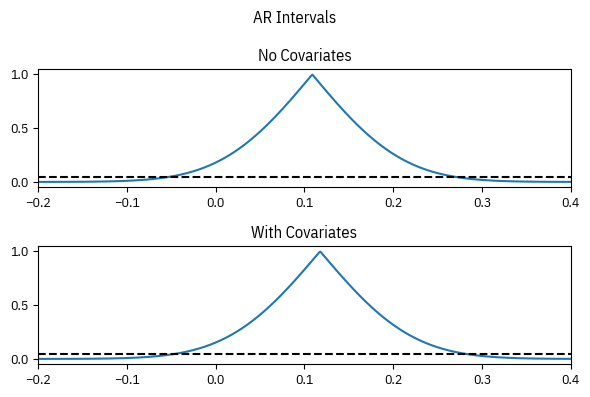

In [34]:
f, ax = plt.subplots(2, 1, figsize=(6, 4))
ax[0].plot(CI1, Pv1)
ax[0].hlines(0.05, l, h, color="k", linestyle="--")
ax[0].set_xlim(l, h)
ax[0].set_title("No Covariates")

ax[1].plot(CI2, Pv2)
ax[1].hlines(0.05, l, h, color="k", linestyle="--")
ax[1].set_xlim(l, h)
ax[1].set_title("With Covariates")
f.set_tight_layout(True)
f.suptitle(r"AR Intervals")